In [45]:
# https://habr.com/ru/company/ods/blog/328372/
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/macbook/jupiter-notebook-to-git-practice/telecom_churn.csv')

In [33]:
df.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [34]:
# Сделаем маппинг бинарных колонок 
# и закодируем dummy-кодированием штат (для простоты, лучше не делать так для деревянных моделей)

d = {'yes' : 1, 'no' : 0}

df['international plan'] = df['international plan'].map(d)
df['voice mail plan'] = df['voice mail plan'].map(d)
df['churn'] = df['churn'].astype('int64')
df = df.drop('phone number', axis=1) # иначе регрессор ругается на этот столбец; да и смысла в его наличии нет

le = LabelEncoder()
df['state'] = le.fit_transform(df['state'])

ohe = OneHotEncoder(sparse=False)

encoded_state = ohe.fit_transform(df['state'].values.reshape(-1, 1))
tmp = pd.DataFrame(encoded_state,  
                   columns=['state ' + str(i) for i in range(encoded_state.shape[1])])
df = pd.concat([df, tmp], axis=1)

In [35]:
X = df.drop('churn', axis=1)
y = df['churn']

# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.33, random_state=42)

# Обучаем логистическую регрессию

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

/Users/macbook/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion matrix, without normalization
[[923  18]
 [143  16]]


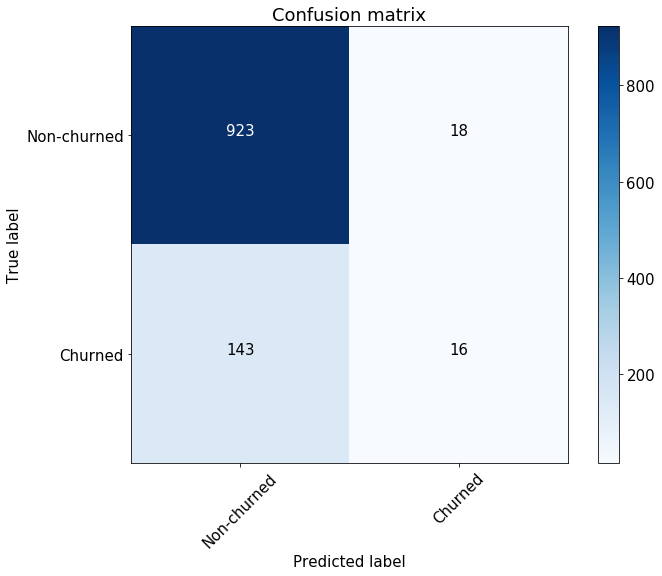

In [42]:
# Воспользуемся функцией построения матрицы ошибок из документации sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
report = classification_report(y_test, lr.predict(X_test), target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.87      0.98      0.92       941
     Churned       0.47      0.10      0.17       159

    accuracy                           0.85      1100
   macro avg       0.67      0.54      0.54      1100
weighted avg       0.81      0.85      0.81      1100



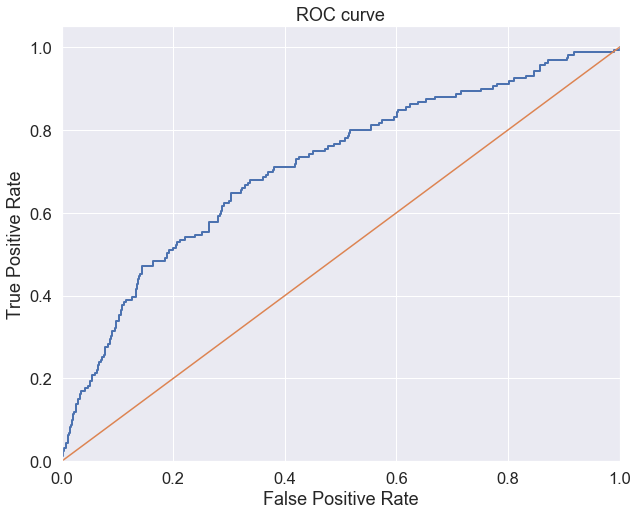

In [46]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [48]:
def logloss_crutch(y_true, y_pred, eps=1e-15):

    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

print('Logloss при неуверенной классификации %f' % logloss_crutch(1, 0.5))
print('Logloss при уверенной классификации и верном ответе %f' % logloss_crutch(1, 0.9))
print('Logloss при уверенной классификации и НЕверном ответе %f' % logloss_crutch(1, 0.1))

Logloss при неуверенной классификации 0.693147
Logloss при уверенной классификации и верном ответе 0.105361
Logloss при уверенной классификации и НЕверном ответе 2.302585
